<a href="https://www.kaggle.com/code/wojciech1/advanced-regression-workflow?scriptVersionId=157474342" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import VarianceThreshold

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

# 1.EDA

## 1.1 Opening Data

In [2]:
path = '/kaggle/input/house-prices-advanced-regression-techniques/'
raw_data = pd.read_csv(path+"train.csv")
raw_data.drop("Id", axis=1, inplace=True)
raw_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>
    
 Quickly checking the initial rows of the dataframe, we observe some columns containing **NaN (Not a Number) values**, which we'll examine later

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [4]:
raw_data["MSSubClass"]= raw_data["MSSubClass"].apply(str) # Converting MSSubClass to string as it is a categorical variable

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>
    
We'll separate the numerical and categorical columns as we plan to use different pre-processing and visualization methods for each.

In [5]:
discrete = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
ordinal = ['MSSubClass', 'Utilities', 'Street','LotShape', 'LandSlope', 'BsmtExposure', 'Functional', 'CentralAir', 'Electrical','GarageFinish','PavedDrive','Fence','ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',  'KitchenQual', 'HeatingQC', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Alley','BsmtFinType1','BsmtFinType2']

# Separating continous and discrete variables 
continous = raw_data.select_dtypes(include=['float64', 'int64']).columns.values.tolist()
for var in discrete:
    if var in continous:
        continous.remove(var)

# Separating nominal and ordinal variables
nominal = raw_data.select_dtypes(include='object').columns.values.tolist()
for var in ordinal:
    if var in nominal:
        nominal.remove(var)

## 1.2 Univariative analysis

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
<h3 align="left"><font color='#4E5672'>🔢 Numeric Features</font></h3>

When dealing with numer ical features, our focus lies in understanding the distribution and statistical properties such as mean, median, and mode. To visualize this information, we commonly employ Distribution plots. Additionally, Boxplots are frequently utilized to unveil the statistical characteristics of each feature. These boxplots help identify potential outliers that may require filtering during the preprocessing stage.

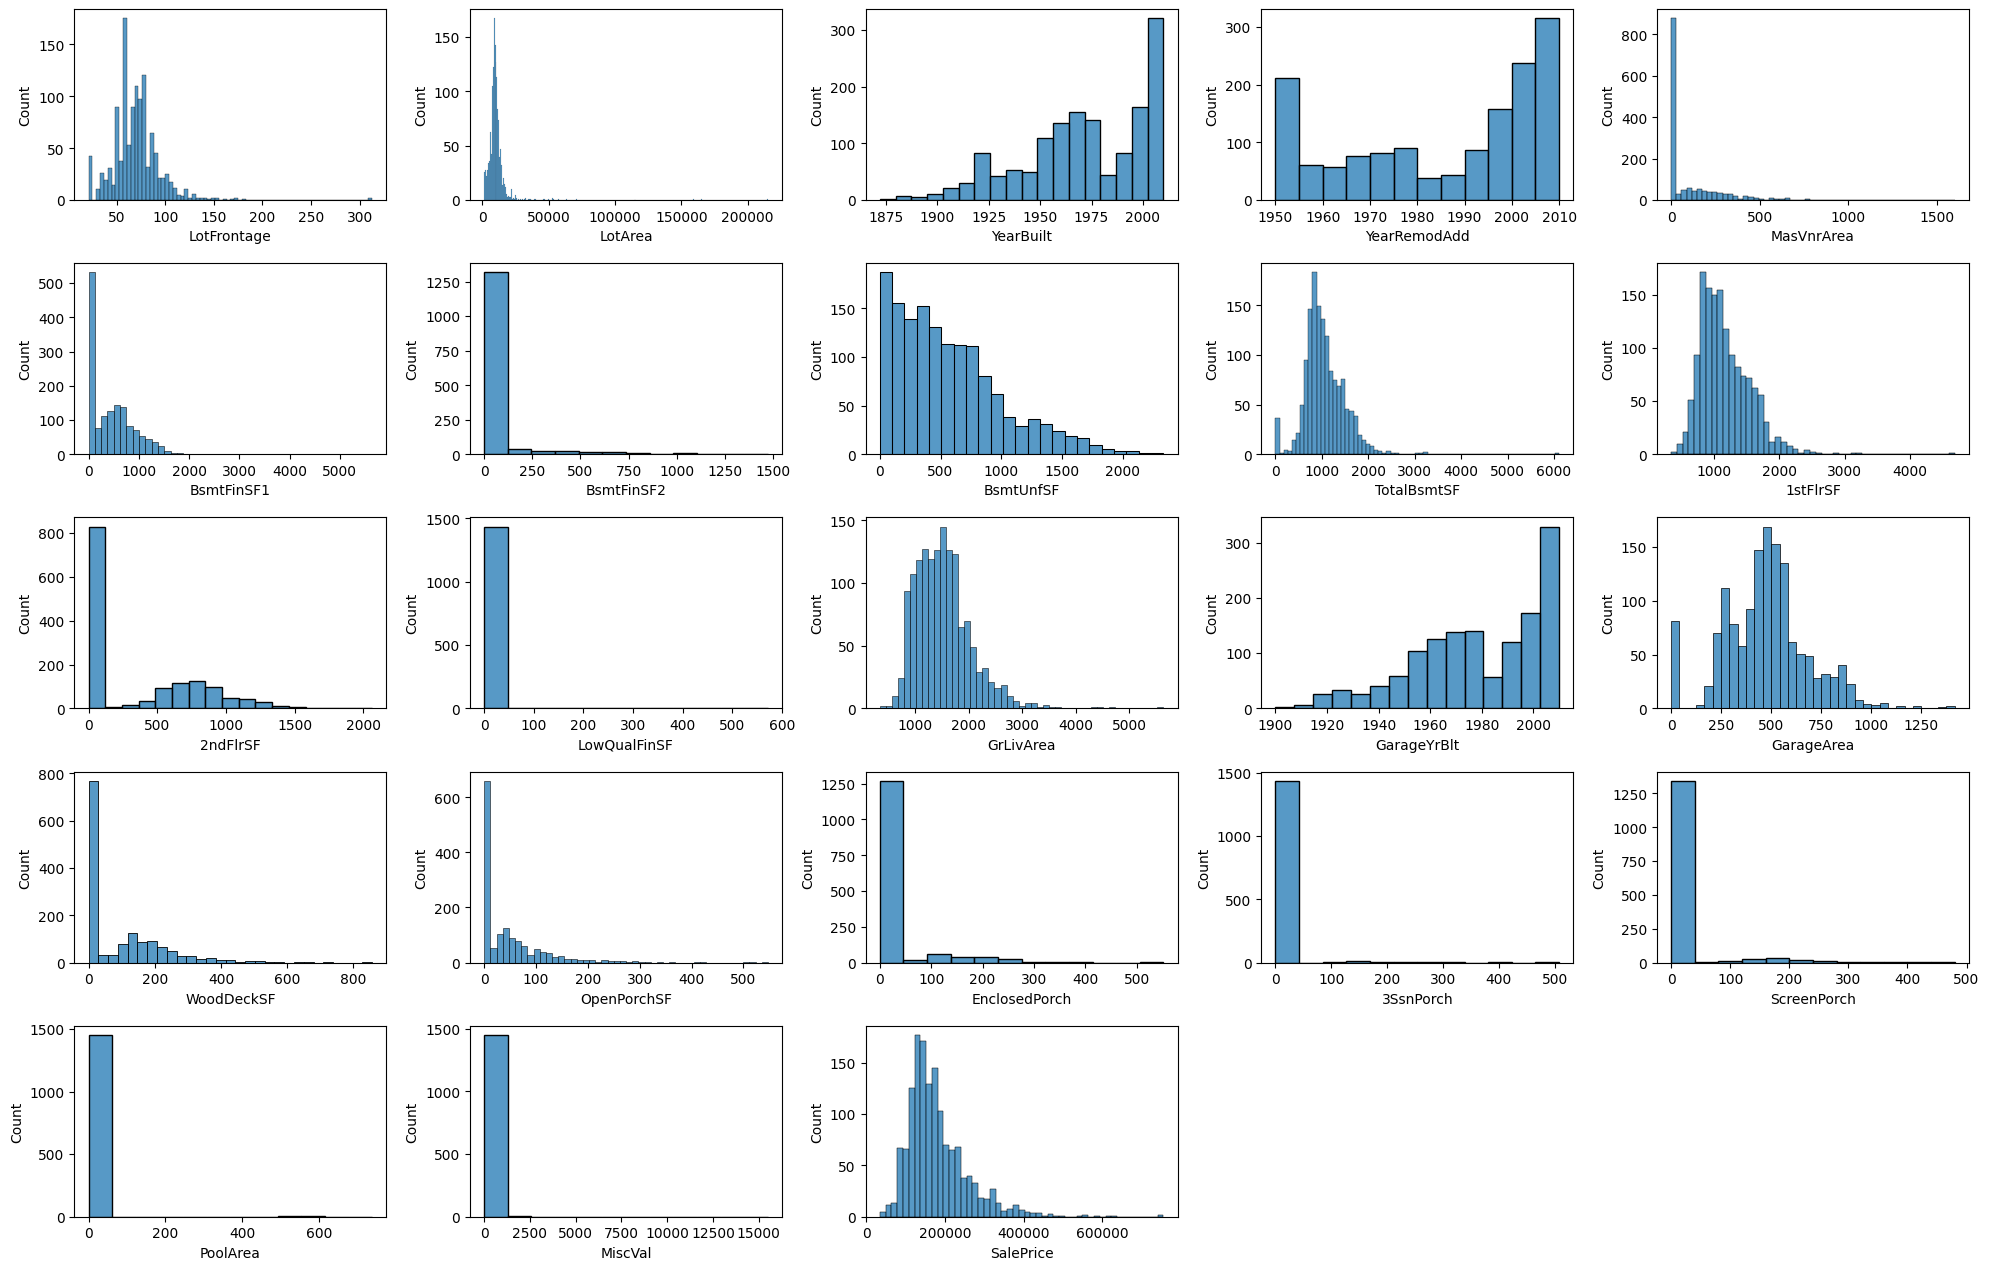

In [6]:
fig = plt.figure(figsize=(20,20))
for index,var in enumerate(continous):
    plt.subplot(8,5,index+1)
    sns.histplot(raw_data[var].dropna(), kde=False)
fig.tight_layout()

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
<h3 align="left"><font color='#4E5672'>Variables with mostly 1 value based on the plots:</font></h3>

* BsmtFinSF2
* LowQualFinSF
* EnclosedPorch
* 3SsnPorch
* ScreenPorch
* PoolArea
* MiscVal

These features show a high skewness, mainly filled with zeros. Lots of zeros don't contribute much to predicting Housing Price. So, during our preprocessing, we'll drop these.

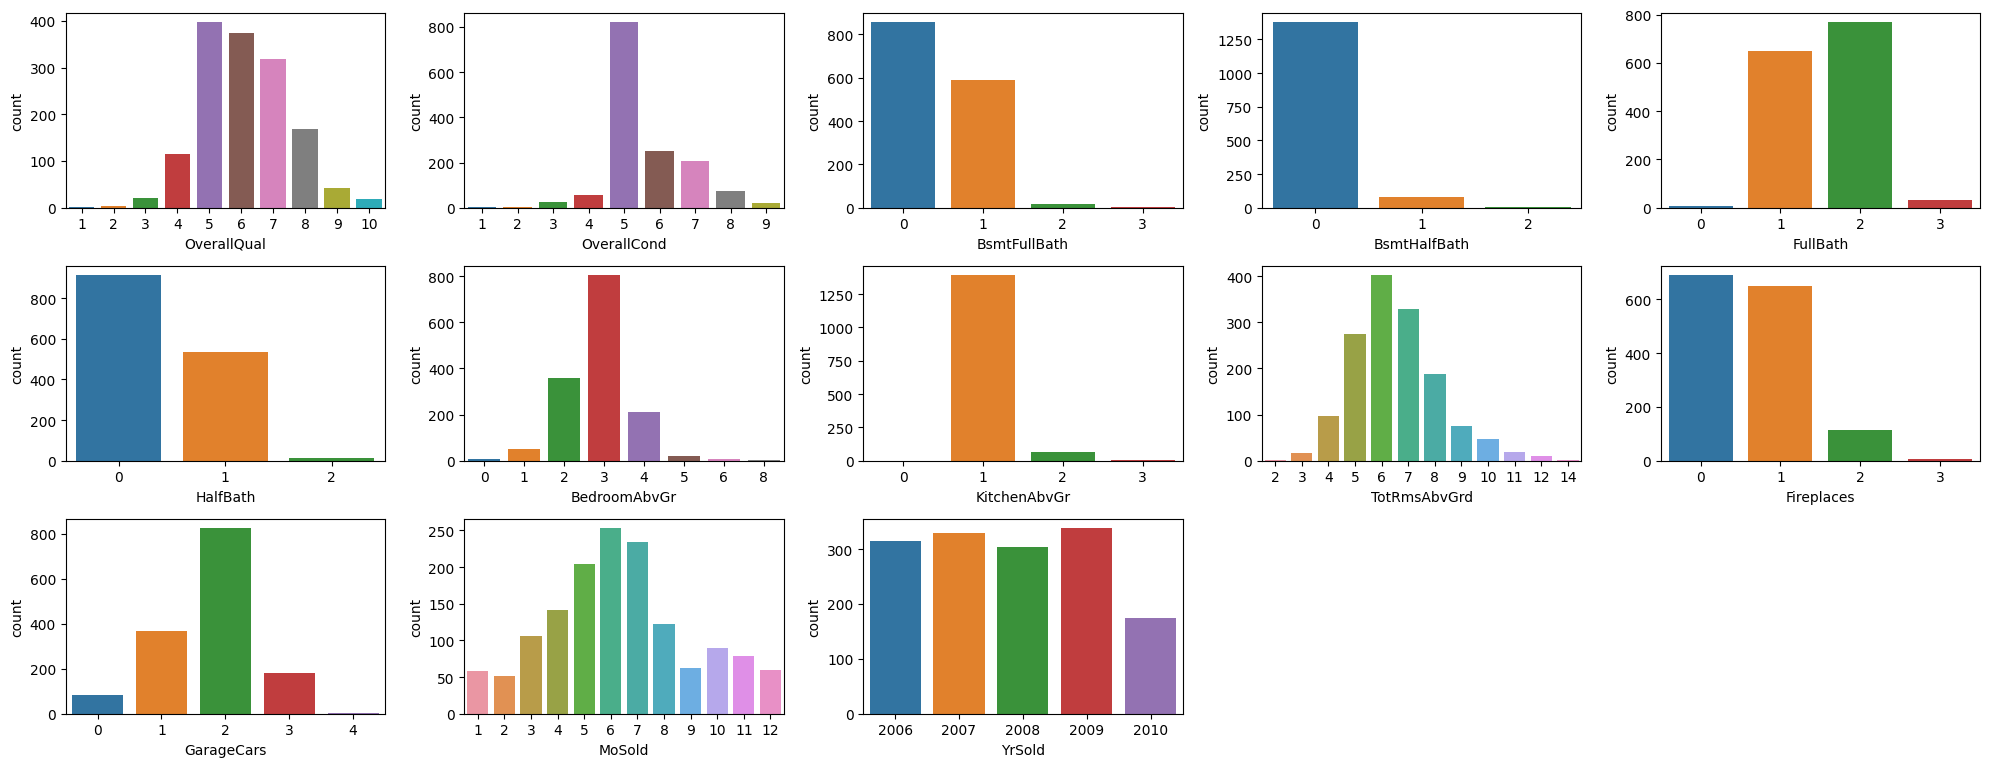

In [7]:
fig = plt.figure(figsize=(20,20))
for index,var in enumerate(discrete):
    plt.subplot(8,5,index+1)
    sns.countplot(x=var, data=raw_data)
fig.tight_layout()

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
<h3 align="left"><font color='#4E5672'>🗂️ Categorical Features:</font></h3>
When it comes to categorical features, we usually turn to countplots. They help us see how many times each unique value appears in each feature. For instance, if a categorical feature like Utilities or Condition2 is mostly stuck on just one value, it's not giving us much useful info. So, during later cleanup, we'll drop those.

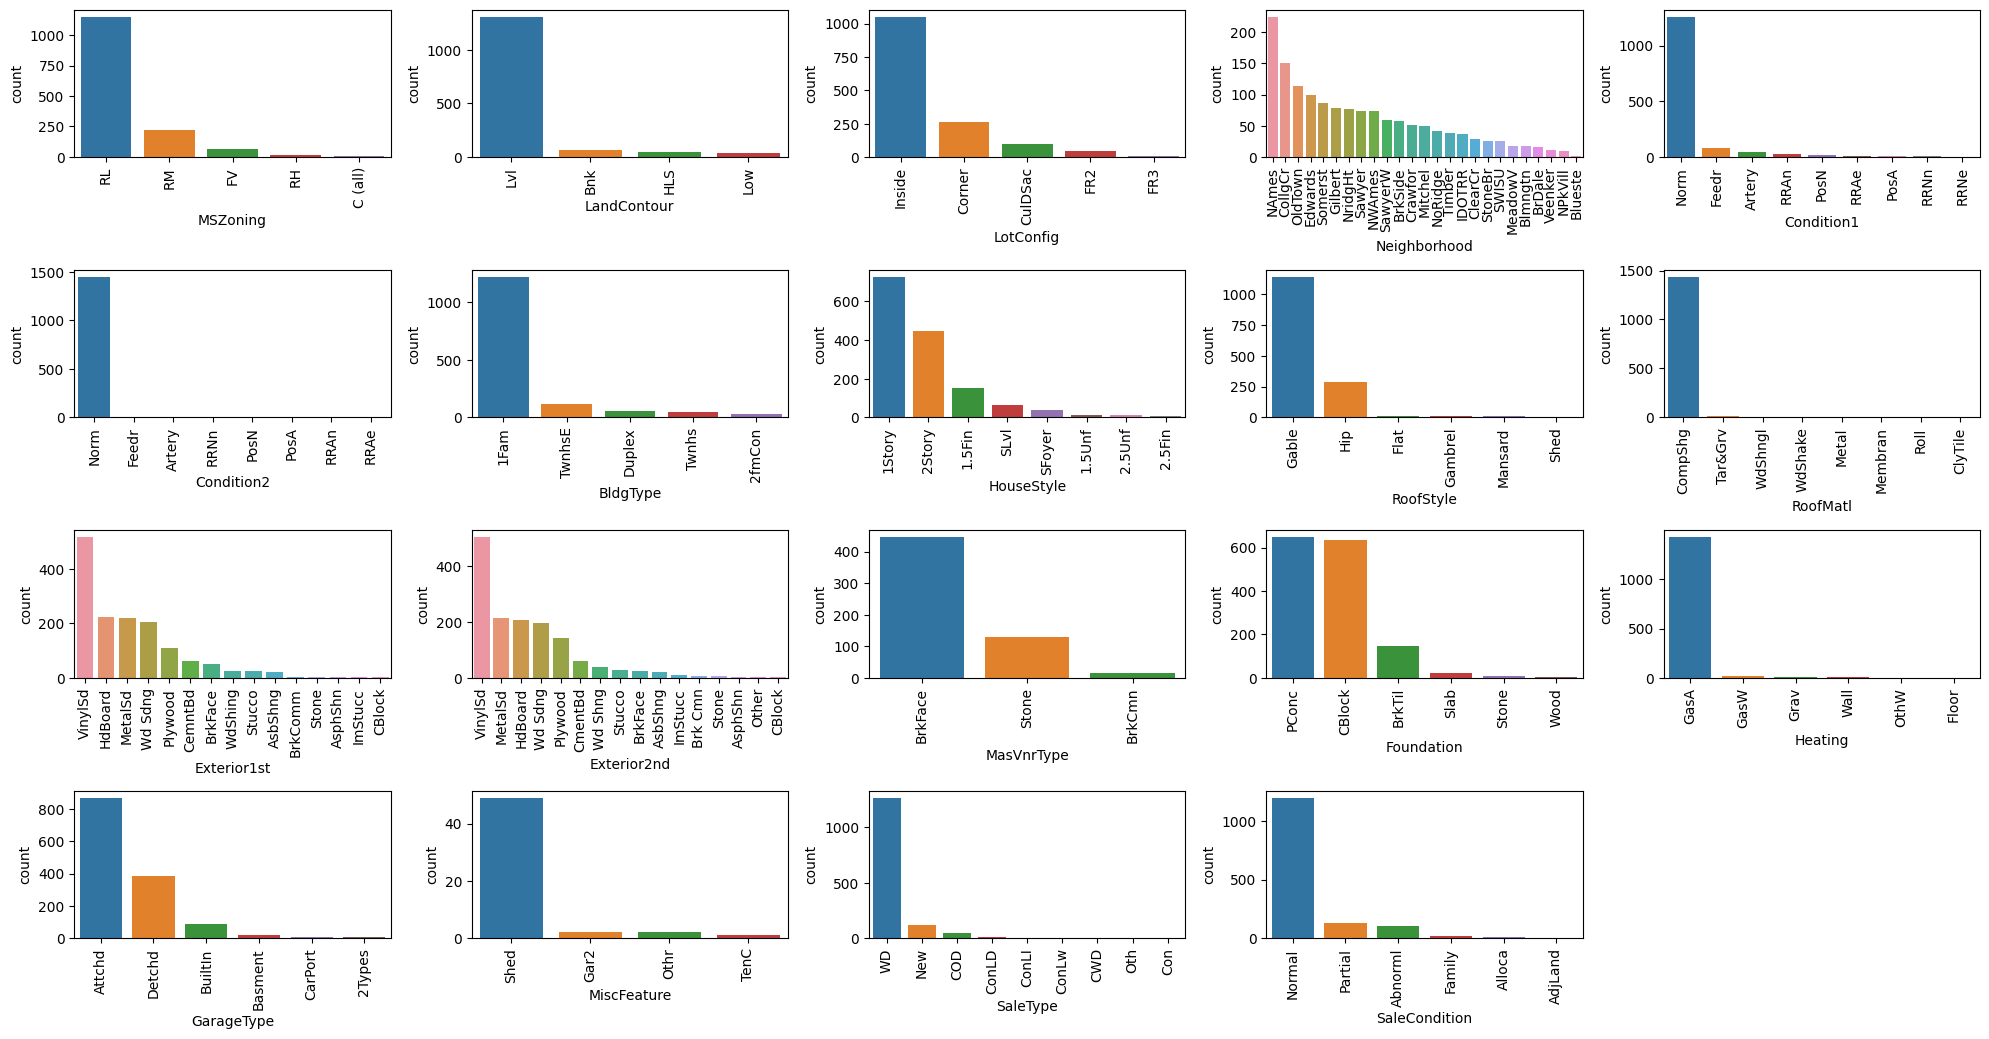

In [8]:
fig = plt.figure(figsize=(20,20))
for index,var in enumerate(nominal):
    plt.subplot(8,5,index+1)
    sns.countplot(x=var, data=raw_data, order = raw_data[var].value_counts().index)
    plt.xticks(rotation=90)
fig.tight_layout()

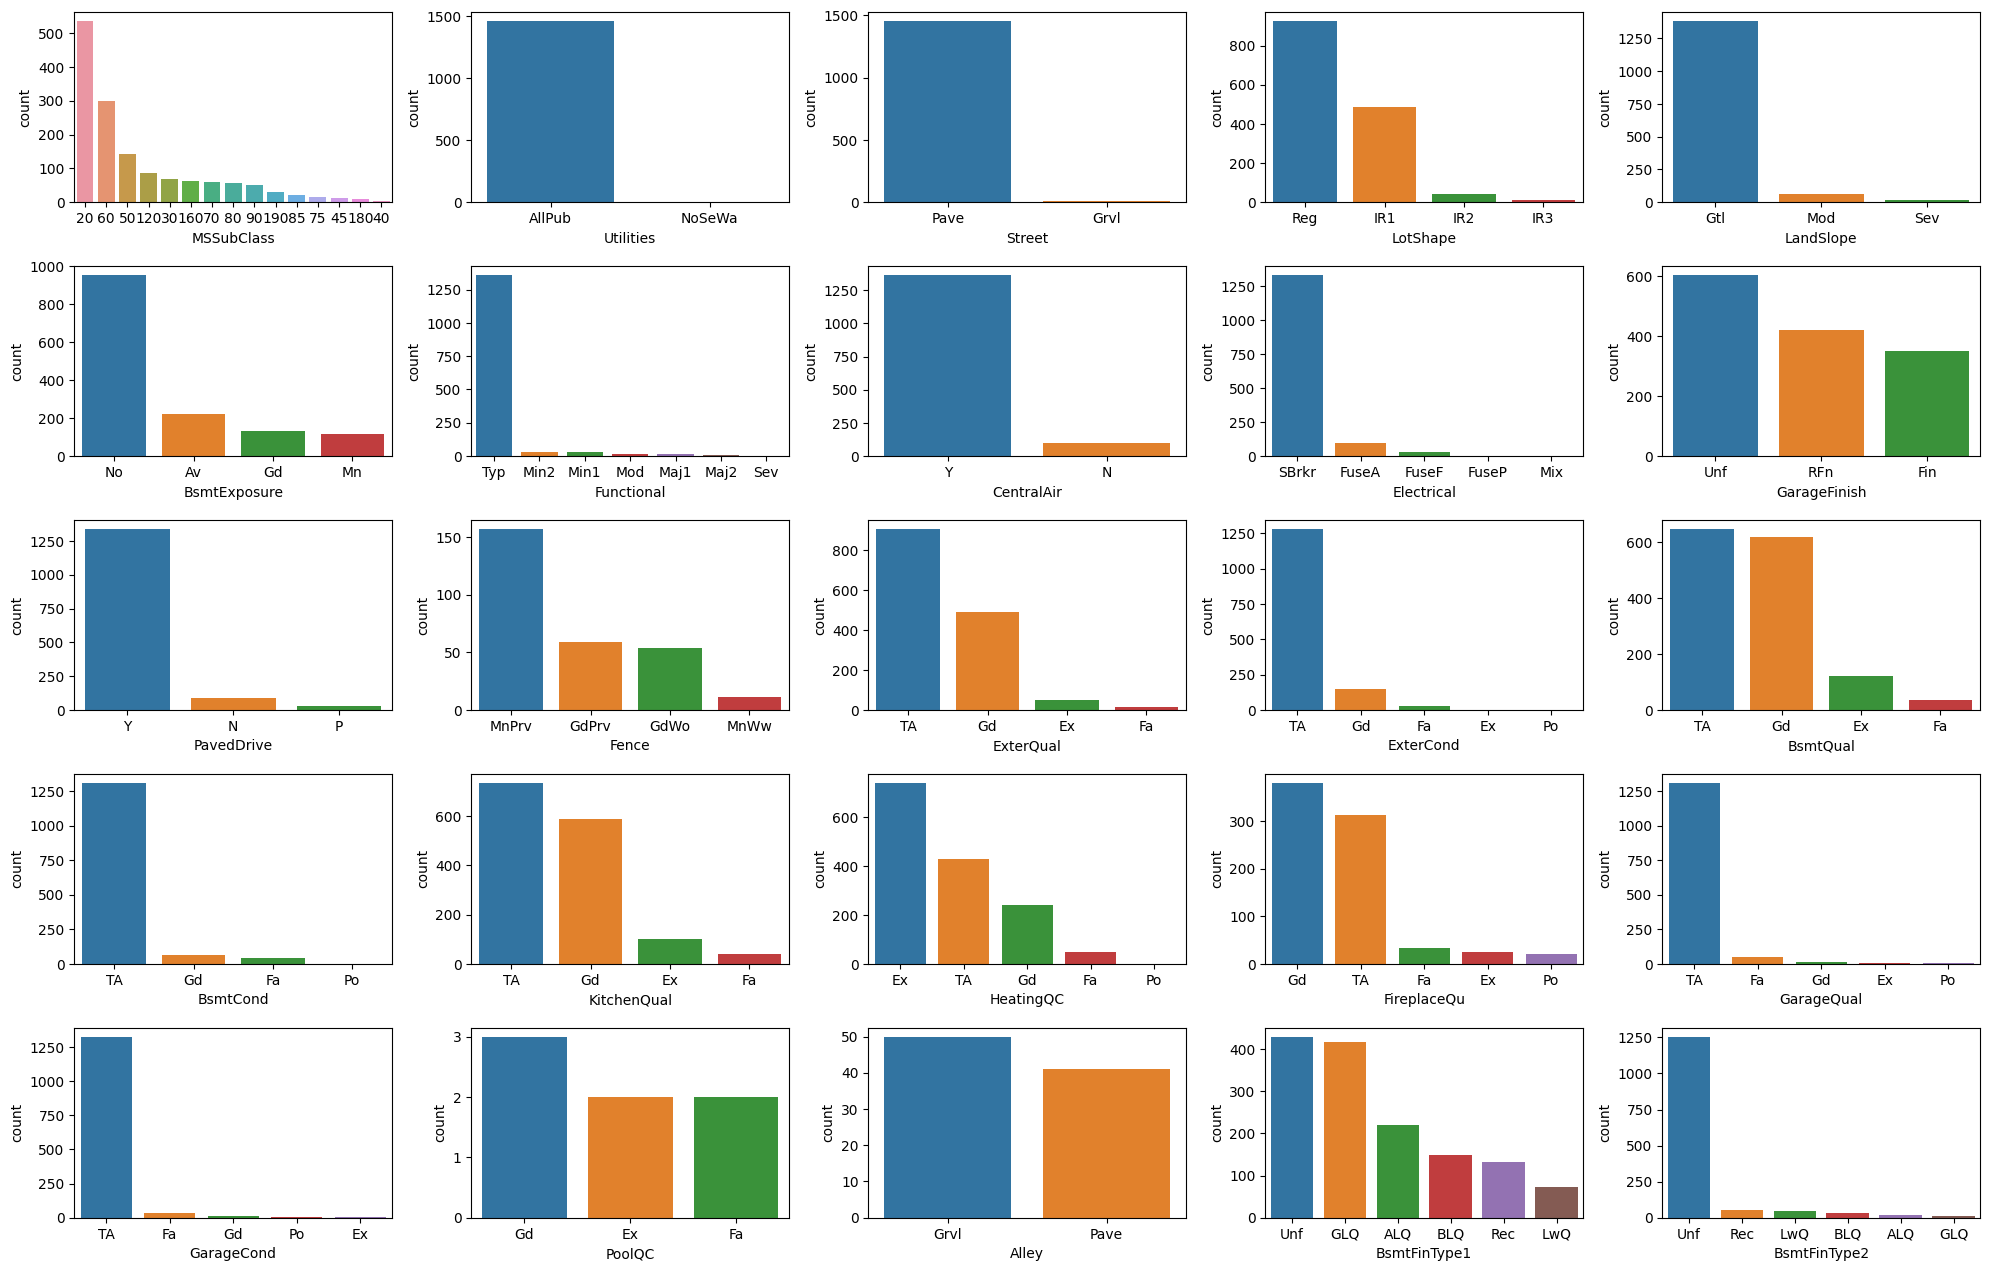

In [9]:
fig = plt.figure(figsize=(20,20))
for index,var in enumerate(ordinal):
    plt.subplot(8,5,index+1)
    sns.countplot(x=var, data=raw_data, order = raw_data[var].value_counts().index)
fig.tight_layout()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note:</font></h3>
    
Univariate Analysis gives us a good solo view of each feature. However, to dig even deeper and unveil patterns in the data, we need to explore how these features relate to each other. That's where Multivariate Analysis comes in, and it's our next step in the analysis journey

### 1.3 Multivariative Analysis

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
<h3 align="left"><font color='#4E5672'>Multivariative Analysis</font></h3>

Multivariative analysis involves examining the relationship or distinctive patterns between two different features. One commonly used technique for this is the Correlation Matrix. It's a useful tool for revealing a linear relationship (Correlation) between any two continuous features. Correlation helps us not only identify which features are crucial for Saleprice but also investigate multicollinearity among our independent predictors.

Multicollinearity occurs when two or more independent variables are highly correlated. This can lead to a loss of precision in our regression coefficients, impacting our ability to pinpoint the most important features for our model

### Variables correlated with each other

<Axes: >

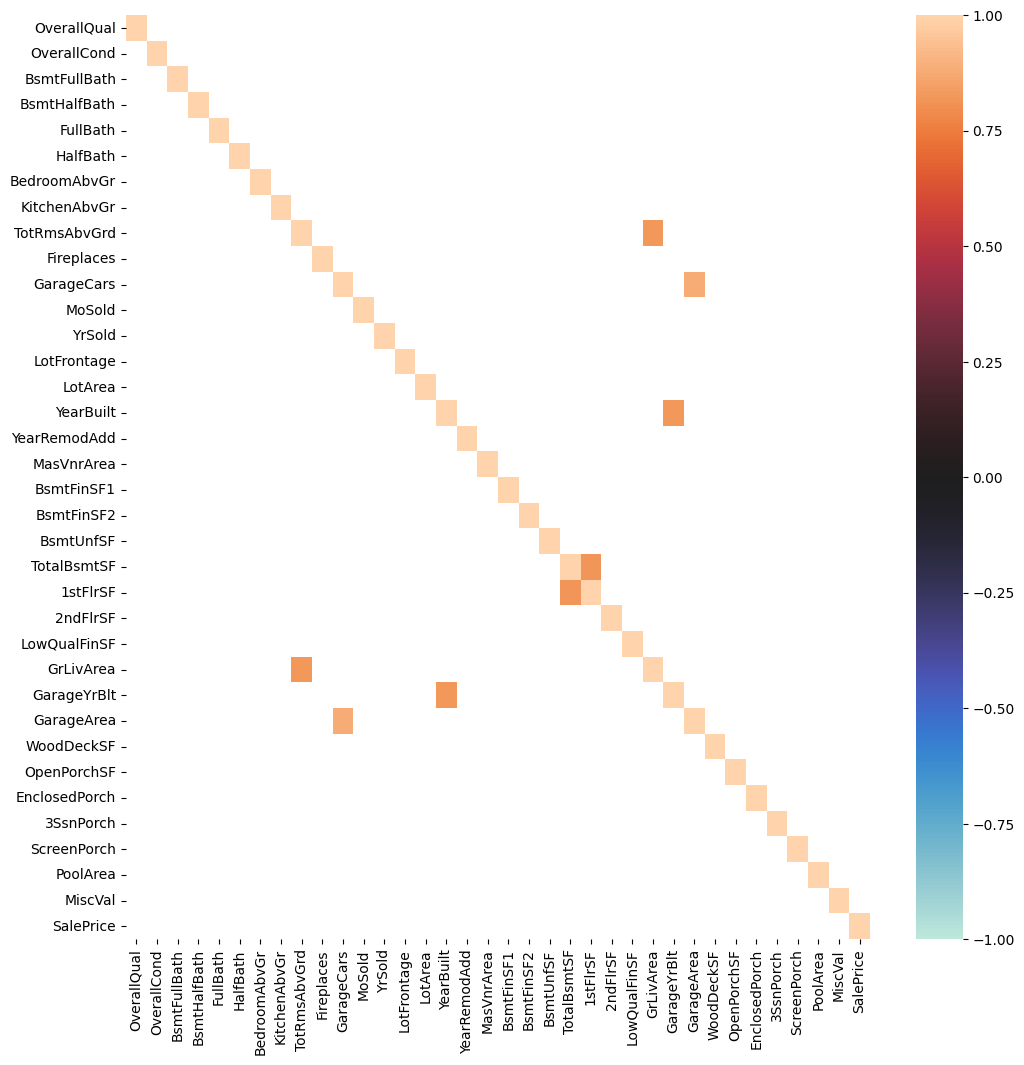

In [10]:
corr_map = raw_data[(discrete+continous)].corr()
plt.subplots(figsize=(12,12))
sns.heatmap(corr_map, vmin=-1, vmax=1, center=0, mask = np.abs(corr_map) < 0.8)

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
<h3 align="left"><font color='#4E5672'>Highly Correlated Variables:</font></h3>
    
* GarageYrBlt and YearBuilt
* TotRmsAbvGrd and GrLivArea
* 1stFlrSF and TotalBsmtSF
* GarageArea and GarageCars

The correlation matrix indicates strong correlations between these pairs of variables. This discovery will be influential in our preprocessing steps as we plan to eliminate highly correlated features to prevent any performance loss in our model.

### Variables correlated with SalePrice

We ranked the strength of the linear relationship between SalePrice and other features. OverallQual and GrLivArea exhibit the most robust linear connection with SalePrice. Therefore, these two features will play a significant role in predicting Housing Price.



<Axes: >

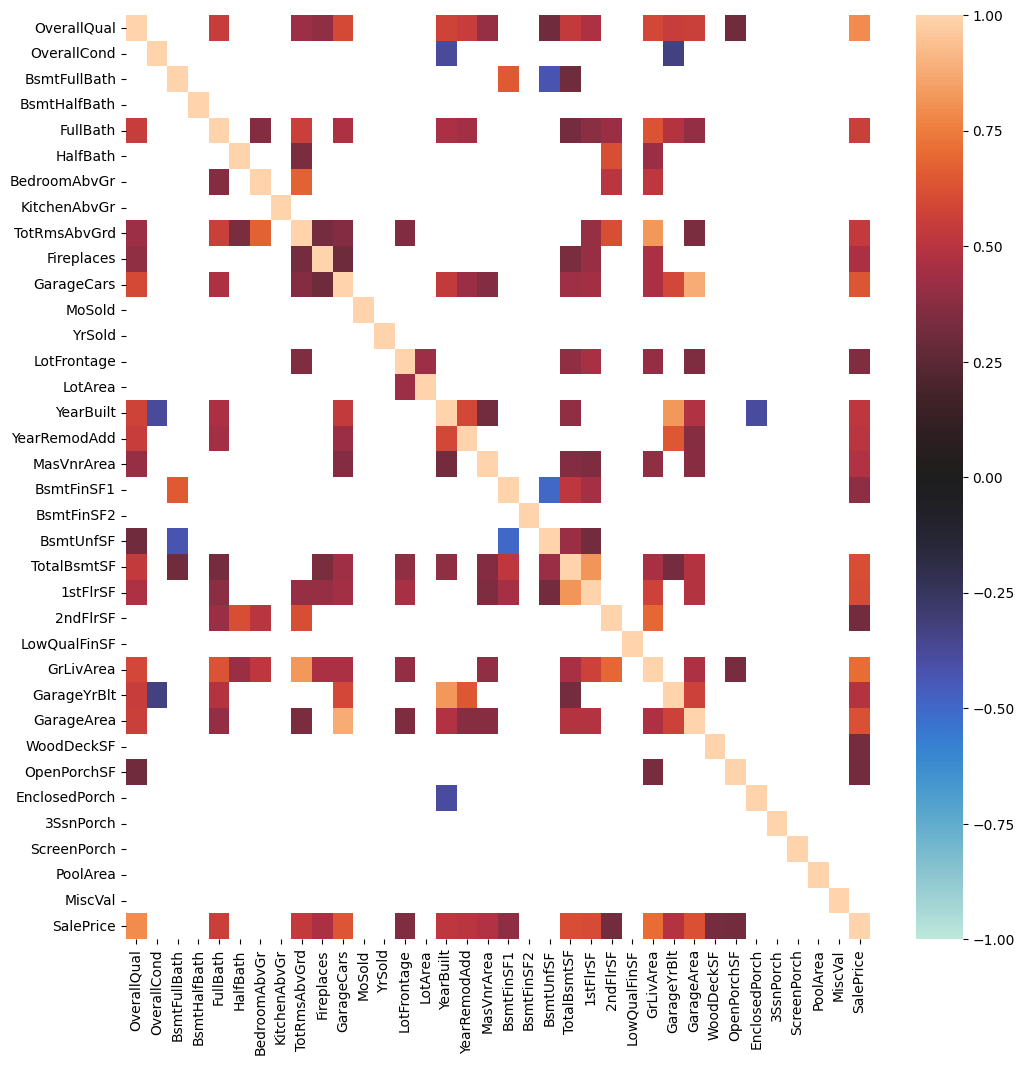

In [11]:
plt.subplots(figsize=(12,12))
sns.heatmap(corr_map, vmin=-1, vmax=1, center=0, mask = np.abs(corr_map) < 0.3)

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
<h3 align="left"><font color='#4E5672'>📈 Scatterplots:</font></h3>

Scatterplots are handy for spotting potential linear relationships among numerical features. While they don't offer precise quantitative evidence on the strength of these relationships like a correlation matrix does, scatterplots excel at visualizing diverse relationships that might go beyond simple linearity, such as quadratic or exponential patterns.



In [12]:
low_corr = corr_map.index[np.abs(corr_map['SalePrice'])<0.3].tolist() # creating a list with features with low correlation with the sales price
high_corr = corr_map.index[np.abs(corr_map['SalePrice'])>=0.3].tolist() # creating a list with other features
high_corr.remove('SalePrice')

**Scatterplots of variables highly correlated with the target**

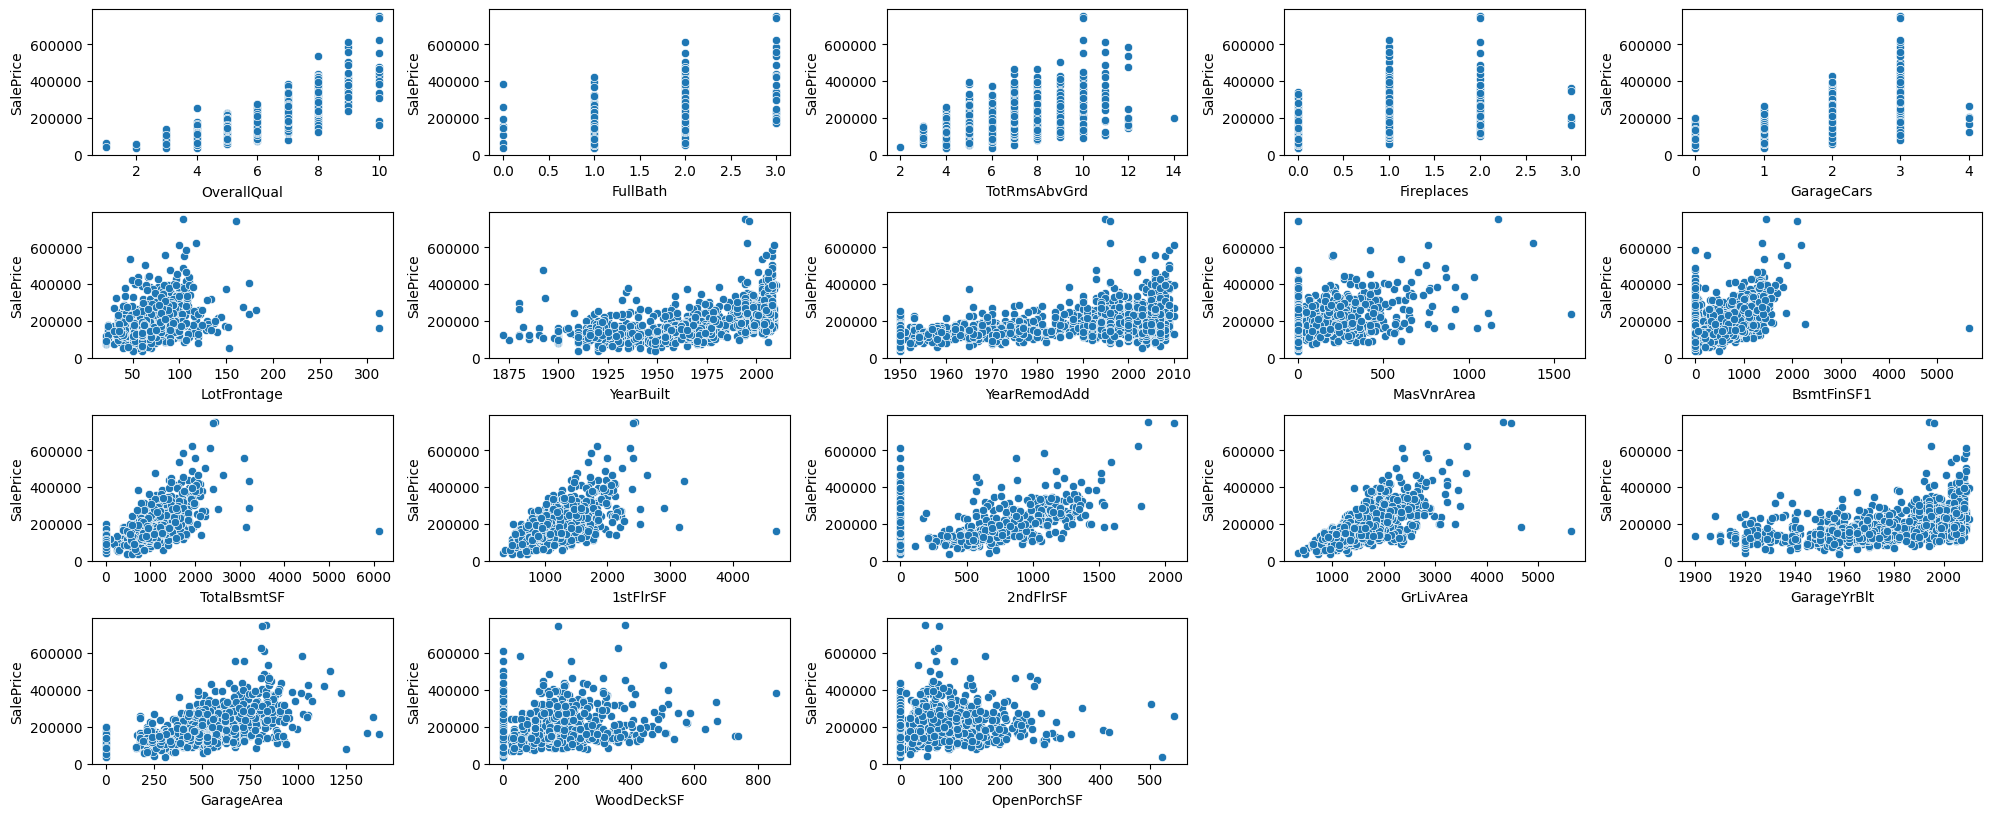

In [13]:
# Scatter plots with highly correlated features
fig = plt.figure(figsize=(20,20))
for index, var in enumerate(high_corr):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=var, y='SalePrice', data=raw_data)
fig.tight_layout(pad=1.0)

**Scatterplots of variables with low correlation to the target**

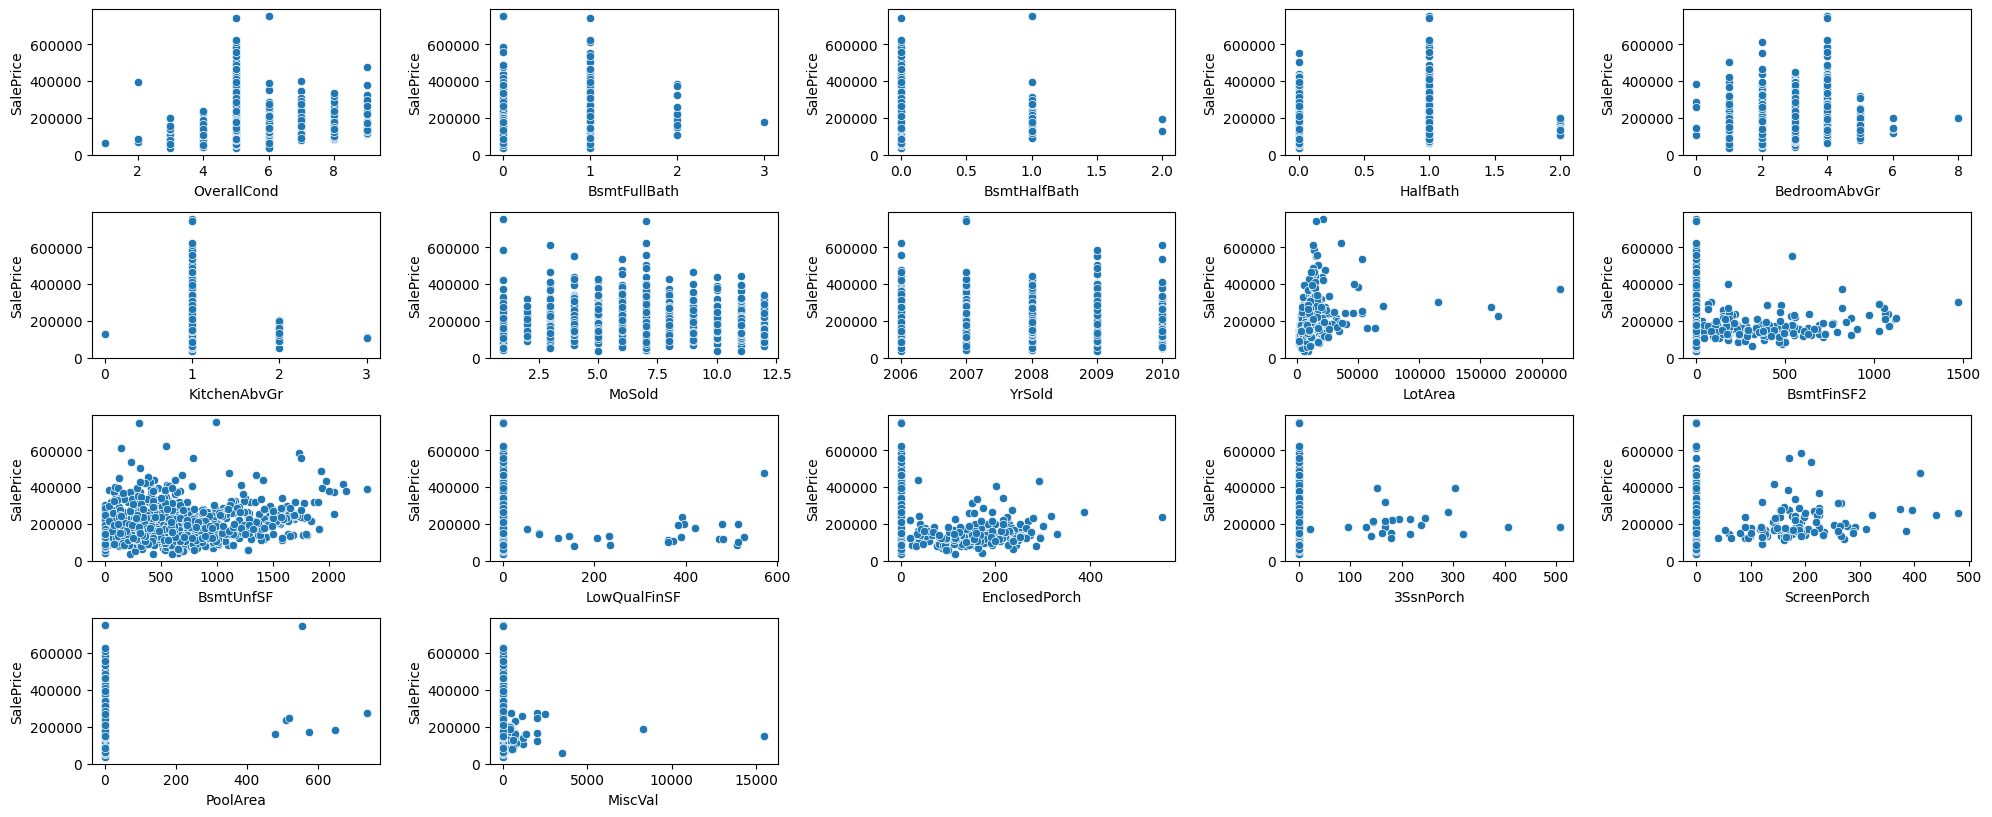

In [14]:
# Other scatter plots
fig = plt.figure(figsize=(20,20))
for index, var in enumerate(low_corr):
    plt.subplot(10,5,index+1)
    sns.scatterplot(x=var, y='SalePrice', data=raw_data)
fig.tight_layout(pad=1.0)

# 2. Preprocessing

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note:</font></h3>
Now that we've wrapped up our data analysis and gained insights through various analyses and visualizations, it's time to use these insights to inform our preprocessing decisions. The goal is to provide clean, error-free data for our model training later on.

Visualization and analysis aren't just for creating appealing graphs—they are crucial for preprocessing!

This section outlines the steps for Data Processing:

1. Removing Redundant Features
2. Dealing with Outliers
3. Filling in Missing Values


## 2.1 Removing features

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
<h3 align="left"><font color='#4E5672'>Removing features with more than 60% of values missing:</font></h3>

Features with Many Missing Values:

* PoolQC
* MiscFeature
* Alley
* Fence
* MasVnrType

Due to the substantial number of missing values in PoolQC, MiscFeature, Alley, Fence and MasVnrType these features are unlikely to provide meaningful information for prediction. Therefore, we will remove them during the preprocessing steps.

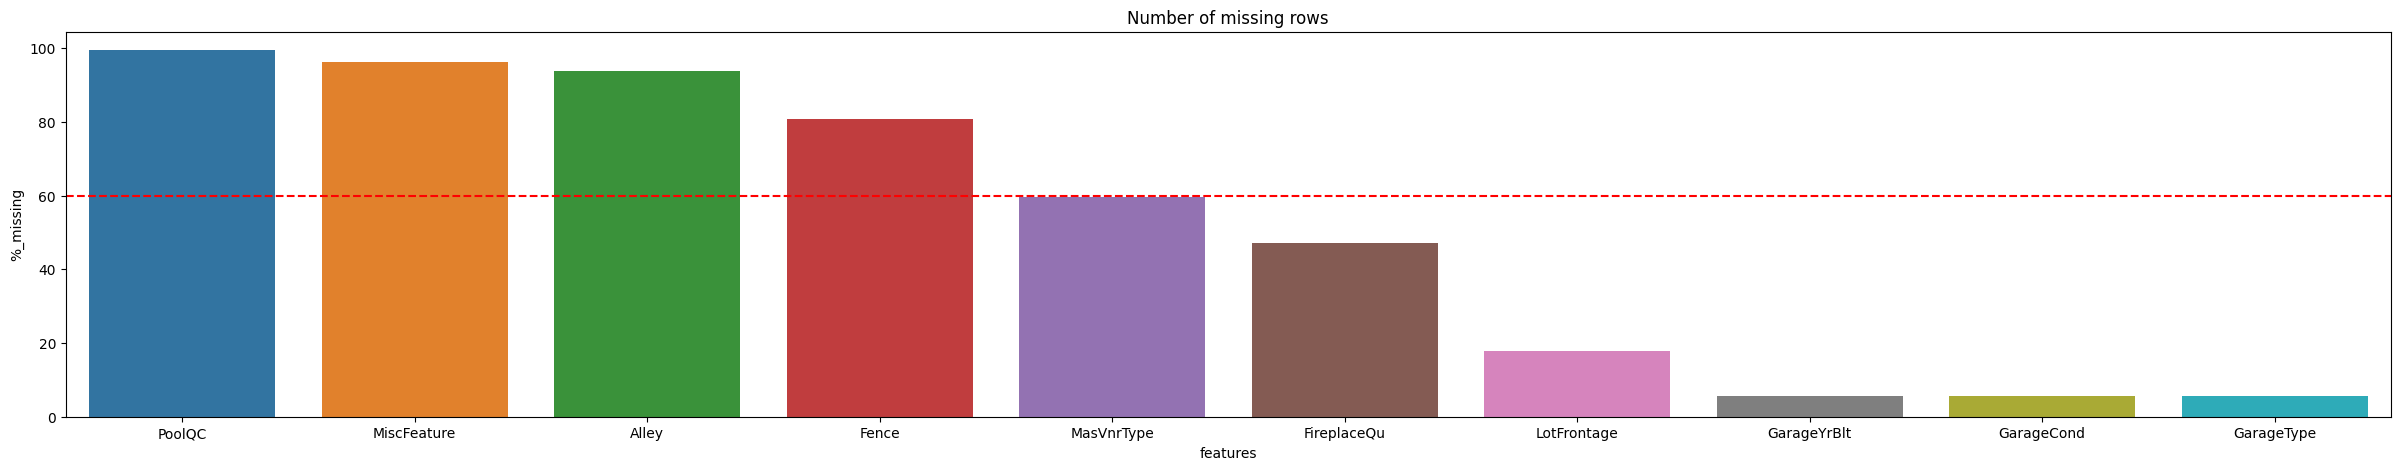

In [15]:
plt.figure(figsize=(30,5))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(100*raw_data.isnull().sum()/len(raw_data), columns=['%_missing']).sort_values(by=['%_missing'],ascending=False).head(10).reset_index()
missing_count.columns = ['features','%_missing']
sns.barplot(x='features',y='%_missing', data = missing_count)
plt.axhline(y=60, color='r', linestyle='--')

In [16]:
data = raw_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], axis=1)

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
<h3 align="left"><font color='#4E5672'>Removing features with the mostly the same value:</font></h3>

During Univariate analysis, we identified features that are predominantly composed of a single value or mostly zeros, which doesn't offer useful information. To address this, we've set a user-defined threshold at 95%. If a column contains more than 95% of the same value, we consider the feature as not providing substantial information, and therefore, we'll remove it during preprocessing.



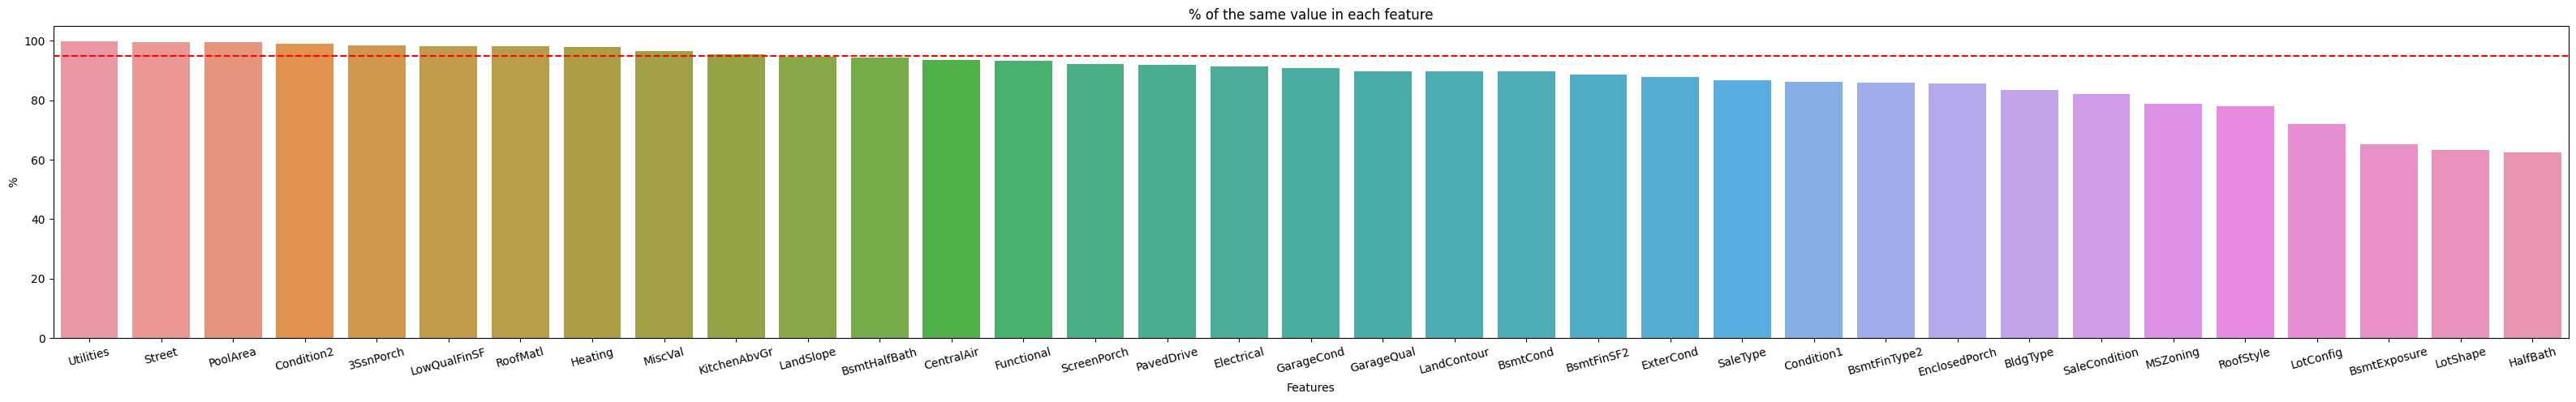

In [17]:
plt.figure(figsize=(40,5))
plt.title('% of the same value in each feature')

most_common_counts = data.apply(lambda x: x.value_counts().max())
missing_count = pd.DataFrame(100*most_common_counts/len(data), columns=['%']).sort_values(by=['%'],ascending=False).head(35).reset_index()
missing_count.columns = ['Features','%']

sns.barplot(x='Features',y='%', data = missing_count)
plt.xticks(rotation=15)
plt.axhline(y=95, color='r', linestyle='--')

In [18]:
def remove_single_val(df, thershold):
    single_val_cols = []
    for col in df.columns:
        counts = df[col].value_counts()
        most_common = counts.iloc[0]
        if (most_common / len(df)) > thershold:
            single_val_cols.append(col)

    return single_val_cols

In [19]:
single_val_cols = remove_single_val(data, 0.95)
data = data.drop(single_val_cols, axis=1)
print("Features removed: ", single_val_cols)

Features removed:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MiscVal']


### Multicollinearity and no correlation to the target

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
<h3 align="left"><font color='#4E5672'>Features with Multicollinearity</font></h3>

* GarageYrBlt and YearBuilt
* TotRmsAbvGrd and GrLivArea
* 1stFlrSF and TotalBsmtSF
* GarageArea and GarageCars

To mitigate the issue of multicollinearity, as explained earlier, we'll proceed to remove these highly correlated features during the preprocessing steps.Removing values with high correlation to each other and low correlation to saleprice

In [20]:
data = data.drop(['GarageYrBlt','TotRmsAbvGrd','1stFlrSF','GarageCars'], axis=1)

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
<h3 align="left"><font color='#4E5672'>Features not cerrelated to the target:</font></h3>

* MoSold
* YrSold

From the plot analysis, it's evident that MoSold (Month Sold) and YrSold (Year Sold) don't exhibit any discernible linear relationship with the target variable SalePrice. As a result, we will remove these features during the preprocessing stage.

Instead we will create a **post-2008** feature that will indicate whether the property was sold before or after the global financial crisis started, as it may have an effect on the prices in some areas, which is not visible on the chart below.



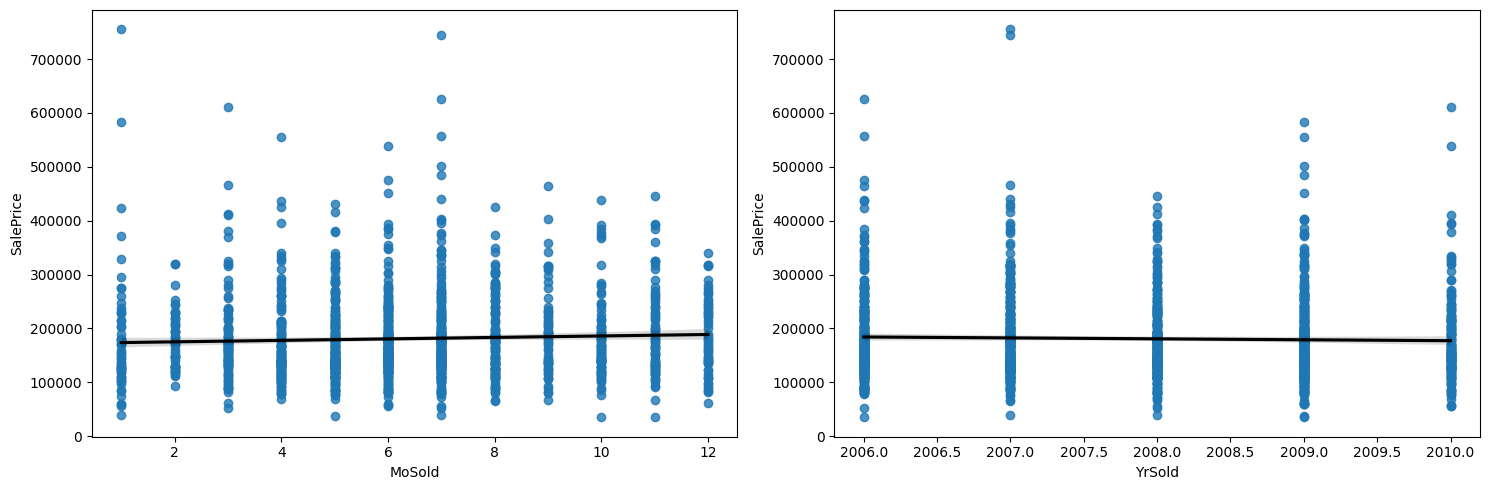

In [21]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.regplot(x=data['MoSold'], y='SalePrice', data=data, ax = axes[0], line_kws={'color':'black'})
sns.regplot(x=data['YrSold'], y='SalePrice', data=data, ax = axes[1], line_kws={'color':'black'})
fig.tight_layout()

In [22]:
data['post2008'] = data['YrSold']>=2008
data = data.drop(['MoSold','YrSold'], axis=1)

## 2.2 Outliers

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>

Removing outliers is crucial to prevent our model's performance from being influenced by extreme values. Identified from the earlier boxplot analysis, the following features exhibit extreme outliers:

* LotFrontage
* LotArea
* BsmtFinSF1
* TotalBsmtSF
* GrLivArea

To maintain model robustness, we will proceed to remove these outliers based on a specified threshold value during the preprocessing stage.



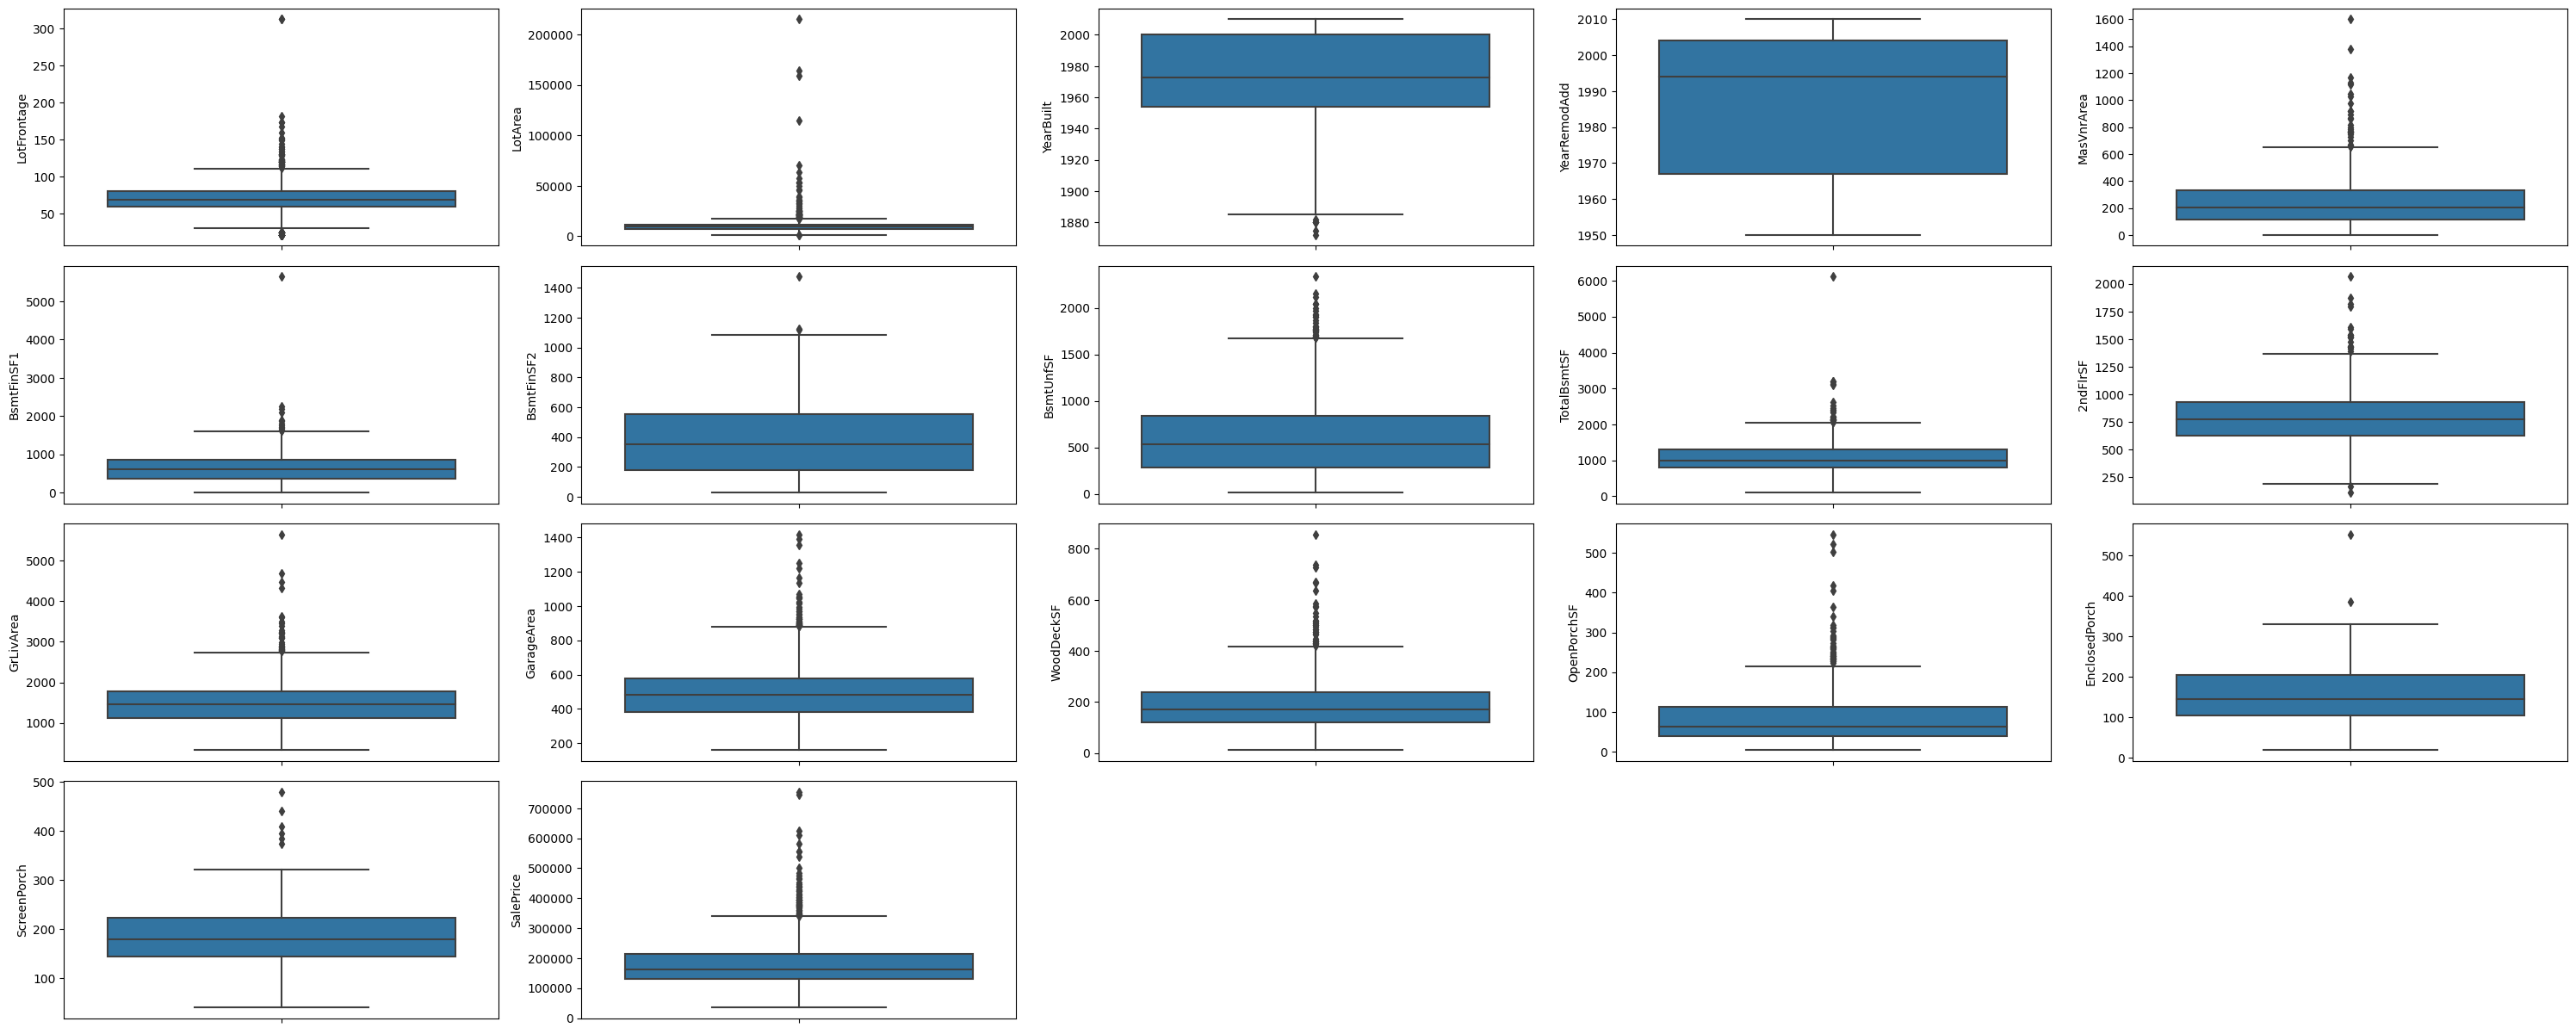

In [23]:
fig = plt.figure(figsize=(30,15))
remaining_cont = [col for col in continous if col in data.columns] 
for index,col in enumerate(remaining_cont):
    plt.subplot(5,5,index+1)
    sns.boxplot(y=col, data=data[data[remaining_cont]>0])
fig.tight_layout(pad=1.0)

In [24]:
data = data[(data['LotFrontage'] < 200) | data['LotFrontage'].isna()]
data = data[(data['LotArea'] < 100000) | data['LotArea'].isna()]
data = data[(data['BsmtFinSF1'] < 4000) | data['BsmtFinSF1'].isna()]
data = data[(data['TotalBsmtSF'] < 5000) | data['TotalBsmtSF'].isna()]
data = data[(data['GrLivArea'] < 4000) | data['GrLivArea'].isna()]

In [25]:
print('Number of outliers removed:', len(raw_data)-len(data))

Number of outliers removed: 9


## 2.3 Missing values

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>
    
Addressing missing values is crucial for our machine learning model, as it cannot handle them. The missing values are denoted as **NAN**, as observed during our data exploration. We will handle these missing values based on our understanding of the respective features during the preprocessing stage.

In [26]:
# Display the number of missing values in each column
missing_values = data.isnull().sum()

# Display the percentage of missing values in each column
missing_percentage = (data.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
}).sort_values(by='Percentage', ascending=False)
# Display the result
missing_info.head(15)

,Missing Values,Percentage
FireplaceQu,690,47.55
LotFrontage,256,17.64
GarageType,81,5.58
GarageFinish,81,5.58
GarageQual,81,5.58
GarageCond,81,5.58
BsmtExposure,38,2.62
BsmtFinType2,38,2.62
BsmtQual,37,2.55
BsmtCond,37,2.55


### Filling ordinal variables with 'NA' that will be encoded later

In [27]:
rem_ordinal = [col for col in ordinal if col in data.columns]
data[rem_ordinal] = data[rem_ordinal].fillna("NA")

### Filling categorical variables with the most common value, separately for each neighbourhood

In [28]:
rem_nominal = [col for col in nominal if col in data.columns]
rem_nominal.remove('GarageType')
data[rem_nominal] = data.groupby("Neighborhood")[rem_nominal].transform(lambda x: x.fillna(x.mode()[0]))

### Filling numerical variables (only LotFrontage and MasVnrArea have missing values)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>For Numerical Features, the standard approach is to fill missing values with the mean of the feature distribution. However, in cases where features like LotFrontage and GarageArea exhibit significant variance in their distribution, a more nuanced approach is needed. Instead of simply calculating the mean of these features, we are grouping them by Neighborhoods. This neighborhood-based grouping allows us to impute the missing values with more accurate mean values, considering the varying LotFrontage and GarageArea means across different neighborhoods.

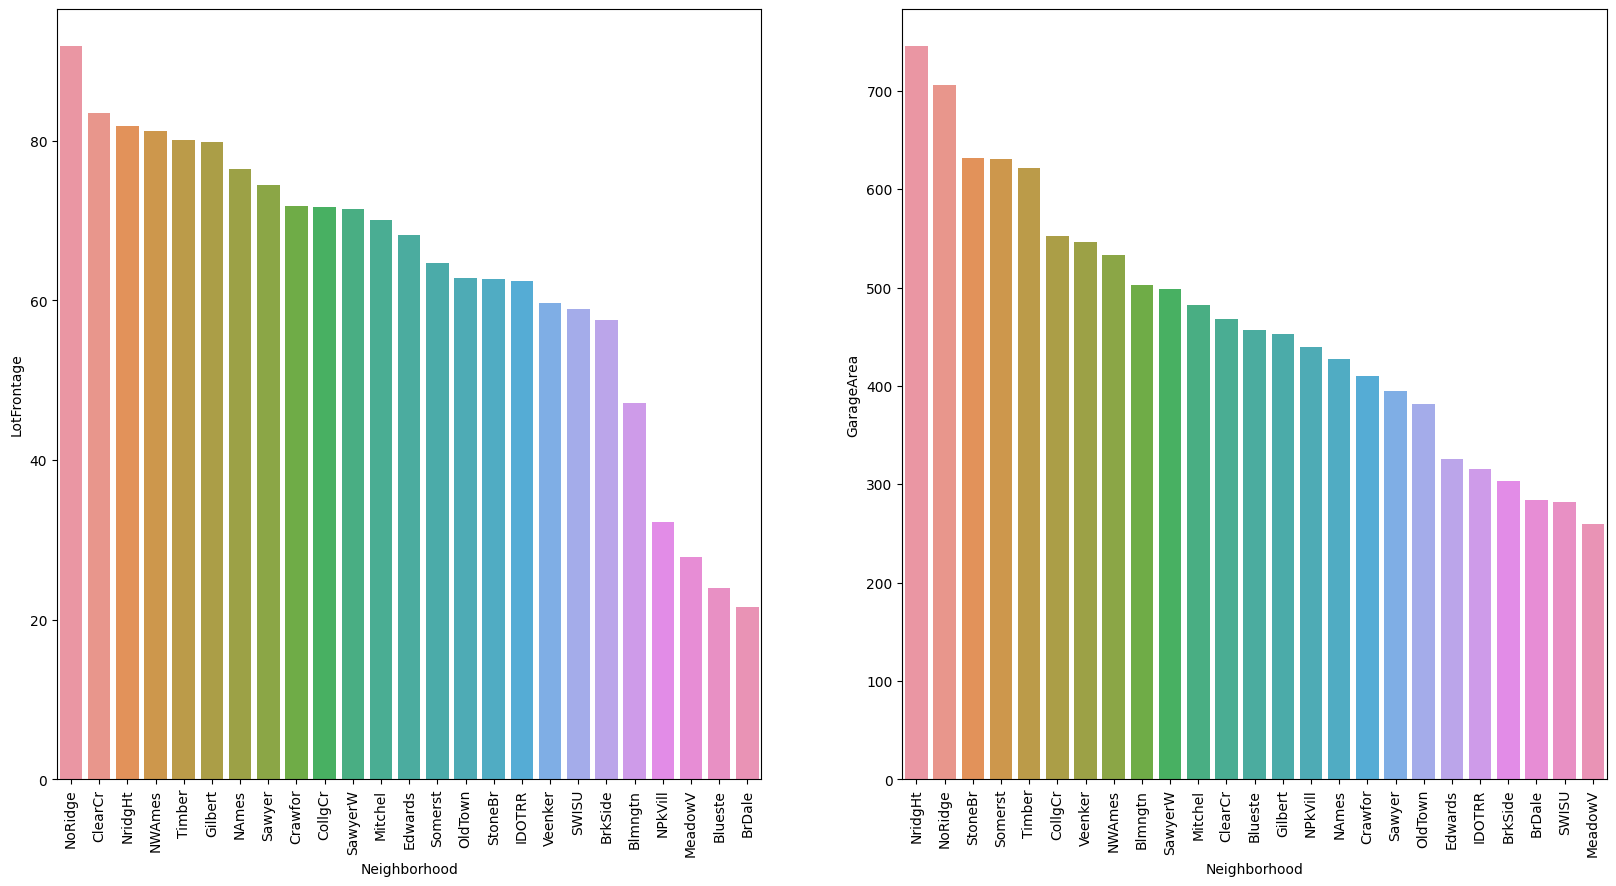

In [29]:
frontage = raw_data.groupby('Neighborhood')['LotFrontage'].mean().reset_index(name='LotFrontage')
garage = raw_data.groupby('Neighborhood')['GarageArea'].mean().reset_index(name='GarageArea')

fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.barplot(x='Neighborhood', y='LotFrontage', data=frontage, ax=ax[0],  order = frontage.sort_values(by=['LotFrontage'], ascending=False)['Neighborhood'])
sns.barplot(x='Neighborhood', y='GarageArea', data=garage, ax=ax[1],  order = garage.sort_values(by=['GarageArea'], ascending=False)['Neighborhood'])
ax[1].tick_params(axis='x', rotation=90)
ax[0].tick_params(axis='x', rotation=90)

In [30]:
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))
data['MasVnrArea'] = data.groupby('Neighborhood')['MasVnrArea'].transform(lambda x: x.fillna(x.mean()))

### Mapping ordinal variables

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>For ordinal columns representing the quality or condition of certain housing features, we'll map the respective strings to numerical values. The mapping will reflect the inherent order, with higher values assigned to better quality or condition.

In [31]:
qual_map = {0: 'NA', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}
type_map = {0: 'NA', 1: 'Unf', 2: 'LwQ', 3: 'Rec', 4: 'BLQ', 5: 'ALQ', 6: 'GLQ'}
exposure_map = {0: 'NA', 1: 'No', 2: 'Mn', 3: 'Av', 4: 'Gd'}

In [32]:
for col in rem_ordinal:
    data[col] = data[col].map(qual_map)
    
data['BsmtFinType1'] = data['BsmtFinType1'].map(type_map)
data['BsmtExposure'] = data['BsmtExposure'].map(exposure_map)

## 2.4 Saleprice distribution 

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>The distribution is skewed to the right, indicating positive skewness where the tail on the right-hand side is longer than the left-hand side, and the mean exceeds the mode. A positively skewed target, such as SalePrice, can impact our machine learning model's performance. To address this, one approach is to apply log transformation on the skewed target, helping to mitigate the skewness and improve the distribution.

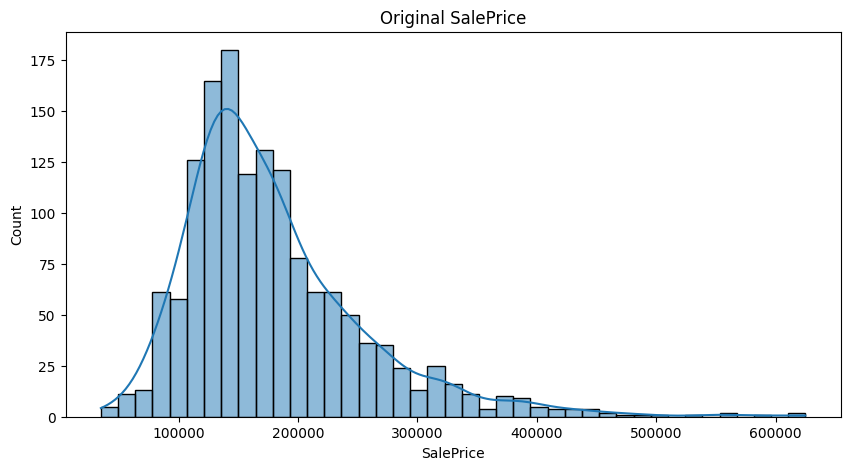

In [33]:
plt.figure(figsize=(10,5))
plt.title("Original SalePrice")
sns.histplot(x='SalePrice', data=data, kde=True);

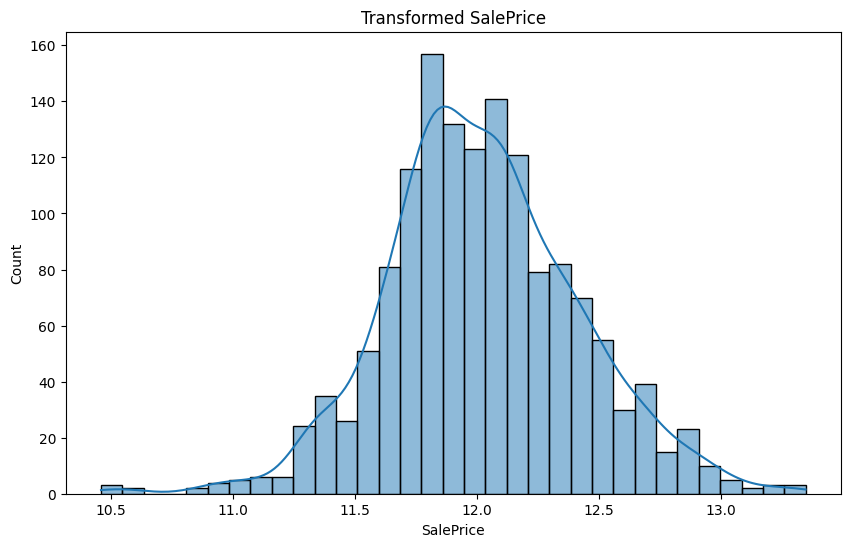

In [34]:
transformed_price = np.log(data['SalePrice'])

plt.figure(figsize=(10,6))
plt.title("Transformed SalePrice")
sns.histplot(transformed_price, kde=True);

# 3. Feature engineering

## 3.1 Sums

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FCFAE5; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>📝 Note</font></h3>

Feature Engineering involves creating new features to potentially improve the prediction of the target variable, SalePrice in this case. In this notebook, we're using domain knowledge to add features.

**New Features:**

* TotalLot: Sum of LotFrontage and LotArea, indicating the total land area.
* TotalSF: Sum of TotalBsmtSF and 2ndFlrSF, representing the total surface area of the house.
* TotalBath: Sum of FullBath and HalfBath, indicating the total number of bathrooms.
* TotalPorch: Sum of OpenPorchSF, EnclosedPorch, and ScreenPorch, representing the total porch area.
* TotalBsmtFin: Sum of BsmtFinSF1 and BsmtFinSF2, indicating the total finished basement area.


In [35]:
data['TotalSF'] = data['TotalBsmtSF'] + data['GrLivArea']
data['TotalBath'] = data['FullBath'] + data['HalfBath']
data['TotalLot'] = data['LotFrontage'] + data['LotArea']
data['TotalBsmtFin'] = data['BsmtFinSF1'] + data['BsmtFinSF2']
data['TotalPorch'] = data['OpenPorchSF'] + data['EnclosedPorch'] + data['ScreenPorch'] + raw_data['3SsnPorch']

## 3.2 Binary features

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">Simple feature engineering involves creating binary columns that indicate the presence (1) or absence (0) of specific house features. This approach enhances the model's ability to capture the impact of these features on the target variable, SalePrice.

In [36]:
columns = ['MasVnrArea','TotalBsmtSF','2ndFlrSF','WoodDeckSF', 'Fireplaces']

for col in columns:
    col_name = col+'_bin'
    data[col_name] = data[col].apply(lambda x: 1 if x > 0 else 0)
    data.drop(col, inplace=True, axis=1)

data['GarageType'] = data['GarageType'].isna().apply(lambda x: 0 if x else 1)

## 3.3 Encoding categorical data

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">To facilitate machine learning, which exclusively learns from numerical data, we'll convert the remaining categorical columns into one-hot features. Using the get_dummies() method, we transform categorical variables into numerical columns suitable for input into our machine learning algorithm. This conversion ensures that the model can effectively learn from and interpret the categorical information.

In [37]:
# One hot encoding categorical data
data = pd.get_dummies(data)

# 4. Modelling

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">In this section, we'll scale the data to enhance optimization during training. Additionally, we'll explore various ensemble methods employed in this notebook for predicting Housing prices. While we touch briefly on hyperparameter tuning here, a dedicated notebook will provide a more detailed explanation of the hyperparameter tuning process and delve into the mathematical aspects of ensemble algorithms.



## 4.1 Splitting training and test set

In [38]:
x_train, x_test, y_train, y_test = train_test_split(data.drop('SalePrice', axis=1), transformed_price, random_state=24, train_size=0.8)

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">Using RobustScaler as a transformation technique involves removing the median and scaling the data based on the interquartile range (IQR). The IQR represents the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). This method is robust to outliers, making it suitable for datasets with numerous outliers that could significantly impact the number of training data.

An important note: Fitting the RobustScaler on both the Train and Test sets, as done previously, is a mistake. This introduces a risk of Data Leakage, where information from outside the training dataset influences model creation. Fitting the scaler on both training and test data means our training data characteristics include the distribution of our test set. This unintentionally incorporates information about the test data into the final training data, preventing a true evaluation of the model on unseen data.

In [39]:
cols = x_train.select_dtypes(np.number).columns
transformer = RobustScaler().fit(x_train[cols])
x_train[cols] = transformer.transform(x_train[cols])
x_test[cols] = transformer.transform(x_test[cols])

## 4.2 XGBoost

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
    
**Ensembling methods**, such as Bagging, Boosting, and Stacking, combine multiple machine learning models to enhance predictive performance by reducing variance and improving bias. In this notebook, the focus is primarily on Boosting for predictions.

**Boosting** improves a class of weak learners sequentially, assigning more weight to misclassified instances in each iteration. Learners, over time, emphasize correcting previously misclassified instances while maintaining accuracy on correctly identified ones. This sequential refinement results in a strong learner capable of accurate predictions, learning from past mistakes and progressively enhancing performance.

**XGBoost** with the gbtree booster is one of the gradient boosting algorithm employing decision trees as weak learners. It minimizes a regularized objective function through gradient descent optimization, preventing overfitting with tree pruning and regularization. The algorithm efficiently handles missing values and is optimized for parallel computing. Known for its speed and performance, XGBoost is widely used in classification, regression, and ranking tasks. Its ensemble approach, combining shallow trees iteratively, makes it effective for capturing complex patterns while maintaining generalization. The gbtree booster's regularization and pruning contribute to its versatility and suitability for various machine learning applications.

In [40]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

## List of parameters for tuning
param_list = {
    'n_estimators' : [50, 100, 500, 1000],
    'max_depth' : [2, 4, 6],
    'min_child_weight' : [0.5, 1, 5, 10],
    'reg_alpha' : [0, 0.001, 0.01, 0.1],
    'reg_lambda' : [0, 0.001, 0.01, 0.1]
}

## Tuning parameters
xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_list,
                              n_iter = 200, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
xgb_search = xgb_reg.fit(x_train, y_train)
best_param = xgb_search.best_params_

In [41]:
# XGB with tune hyperparameters
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror', **best_param)

## Tuning learning rate
lr_list = {'learning_rate' : np.arange(0, 0.51, 0.05)}
xgb_lr = RandomizedSearchCV(estimator = xgb, param_distributions = lr_list,
                              n_iter = 10, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
lr_search = xgb_lr.fit(x_train, y_train)
best_param.update(lr_search.best_params_)

In [42]:
## XGB model with optimised parameters and learning rate
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror', **best_param)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## 4.3 Linear Regression

In [43]:
LR = LinearRegression()
LR.fit(x_train, y_train)

LinearRegression()

## 4.4 Results & Conclusion

In [44]:
preds_LR = LR.predict(x_test) 
preds_xgb = xgb.predict(x_test) 

In [45]:
RMSE_LR = np.sqrt(MSE(y_test, preds_LR))
RMSE_xgb = np.sqrt(MSE(y_test, preds_xgb))

In [46]:
print("Linear Regression RMSE: ", round(RMSE_LR,4))
print("XGBoost RMSE: ", round(RMSE_xgb,4))

Linear Regression RMSE:  0.1045
XGBoost RMSE:  0.1135


 The observation that the distribution of predicted prices with XGBoost looked closer to the actual prices suggests that the model captured complex relationships more effectively.

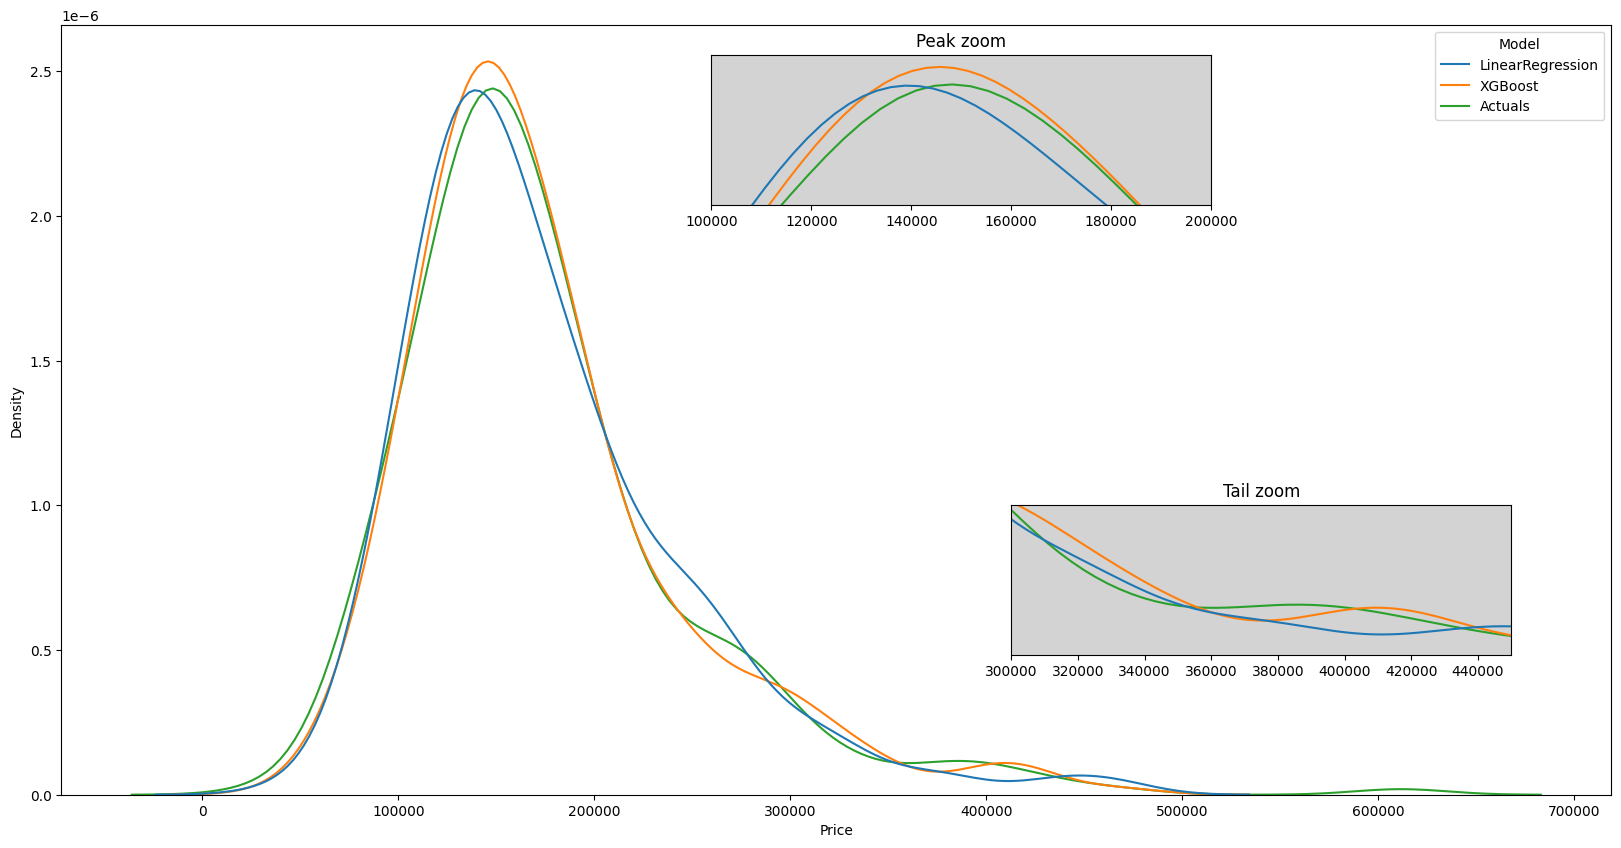

In [47]:
plot_data = pd.DataFrame({'Price': np.concatenate([np.exp(preds_LR), np.exp(preds_xgb), np.exp(y_test)]),
                           'Model': np.repeat(['LinearRegression', 'XGBoost', 'Actuals'], len(y_test))})


fig, ax = plt.subplots(figsize=(20, 10))
sns.kdeplot(x='Price', hue='Model', data=plot_data, ax=ax)

# Zoom plot for the tail of the distribution
ax2 = plt.axes([0.6, 0.25, .25, .15], facecolor='lightgrey')
sns.kdeplot(x='Price', hue='Model', data=plot_data, ax=ax2, legend=False).set(xlabel=None, ylabel=None)
ax2.set(yticklabels=[])
ax2.tick_params(left=False)
ax2.set_title('Tail zoom')
ax2.set_xlim([300000, 450000])
ax2.set_ylim([0., 0.35e-6])


# Zoom plot for the peak of the distribution
ax3 = plt.axes([0.45, 0.7, .25, .15], facecolor='lightgrey')
sns.kdeplot(x='Price', hue='Model', data=plot_data, ax=ax3, legend=False).set(xlabel=None, ylabel=None)
ax3.set(yticklabels=[])
ax3.tick_params(left=False)
ax3.set_title('Peak zoom')
ax3.set_xlim([100000, 200000])
ax3.set_ylim([1.8e-6, 2.6e-6]);

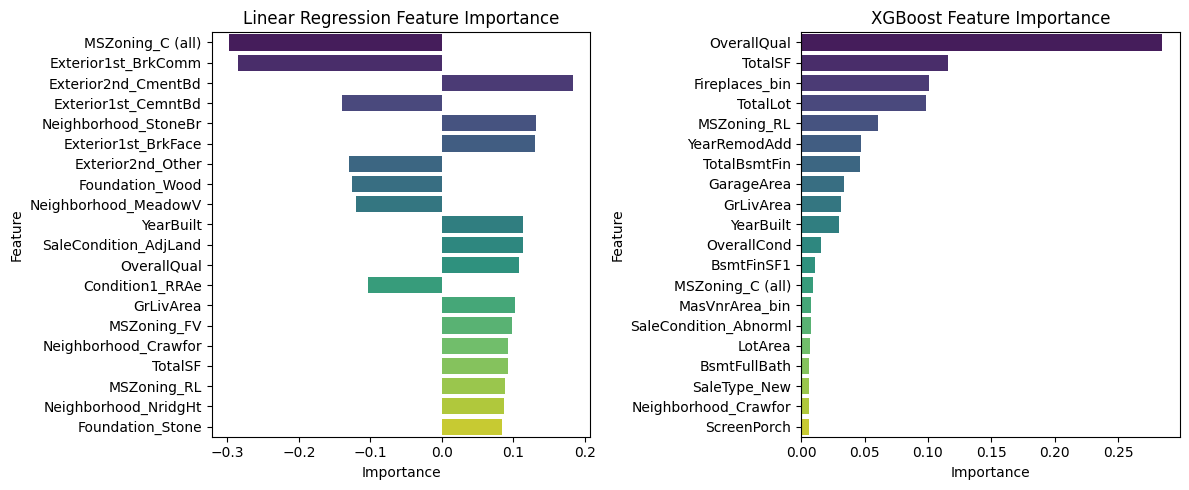

In [48]:
# Feature importance for Linear Regression
LR_feature_importance = LR.coef_

# Feature importance for XGBoost
xgb_feature_importance = xgb.feature_importances_

# Create DataFrames for better visualization
LR_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': LR_feature_importance})
xgb_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': xgb_feature_importance})

# Keeping top 15 features
LR_df = LR_df.loc[(LR_df['Importance']).abs().sort_values(ascending=False).head(20).index]
xgb_df = xgb_df.loc[(xgb_df['Importance']).abs().sort_values(ascending=False).head(20).index]

# Plotting using Seaborn
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=LR_df, palette='viridis')
plt.title('Linear Regression Feature Importance')

plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=xgb_df, palette='viridis')
plt.title('XGBoost Feature Importance')

plt.tight_layout()
plt.show()

<div style="border-radius:10px; border:#4E5672 solid; padding: 15px; background-color: #F8F1E8; font-size:100%; text-align:left">
<h3 align="left"><font color='#4E5672'>🔎 Conclusion</font></h3>

In this notebook, we explored the House Prices dataset and performed extensive data analysis, preprocessing, and feature engineering to prepare the data for predictive modeling. The primary objective was to predict house prices using two different models: Linear Regression and XGBoost.

**Key Findings:**

* **Important Features:**

    * The most crucial factors influencing house prices were identified as the total square footage (TotalSF) and the overall quality (OverallQual) of the property. These findings align with common expectations in real estate, emphasizing the significance of size and quality in determining property values.
    
* **Model Performance:**

    * Linear Regression exhibited a slightly better Root Mean Squared Error (RMSE) compared to XGBoost. However, the choice between models goes beyond RMSE and involves considering additional factors.

* **Distribution of Predicted Prices:**

    * The distribution of predicted prices with XGBoost looked closer to the actual prices, indicating that the model captured complex relationships and patterns more effectively.

* **Feature Importance:**

    * Notably, there were discrepancies in feature importance between Linear Regression and XGBoost. Linear Regression emphasized features differently, which could be attributed to its assumption of linear relationships.

* **Implications:**

    * The choice between models should be guided by the specific goals and requirements of the application. Consideration of trade-offs, such as interpretability versus complexity, plays a crucial role in the decision-making process.
In conclusion, this analysis showcases the importance of a comprehensive evaluation that goes beyond quantitative metrics like RMSE. It underscores the need to balance simplicity and complexity, emphasizing the interpretability of results and the ability to capture intricate patterns for effective predictive modeling. The observed discrepancies in feature importance highlight the diverse insights offered by different models and the importance of selecting models that align with the specific objectives of the analysis.






